# GAN
In this exercise we implement a GAN to fit three different data distrobutions.
In each sectoin have hyper parameter variables (i.e. batch size, epochs, ect.) which were used.
The noise we generated as the input for the generator was 1x2 dim noise between [-1,1] and the activation function used was LeakyRelu. GANs are very delicate to train. We noticed adding batch normalization added in training and making the noise in the range [-1,1] aided the GAN. Additionally for more complex distrobutions we noticed that varying batch sizes where helpful that way the GAN was exposed to a wider variety of samples early in the training.

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

from IPython import display

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

from generate_data import get_data
import numpy as np

matplotlib_is_available = True
try:
  from matplotlib import pyplot as plt
except ImportError:
  print("Will skip plotting; matplotlib is not available.")
  matplotlib_is_available = False

# np.random.seed(7)
# torch.manual_seed(7)

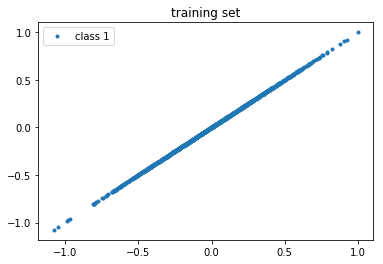

In [3]:
X = get_data(1000, 'line')
plt.plot(X[:,0], X[:,1], '.', label='class 1')
plt.title('training set')
plt.legend()
plt.show()

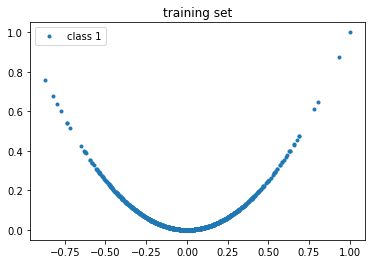

In [4]:
X = get_data(1000, 'par')
plt.plot(X[:,0], X[:,1], '.', label='class 1')
plt.title('training set')
plt.legend()
plt.show()

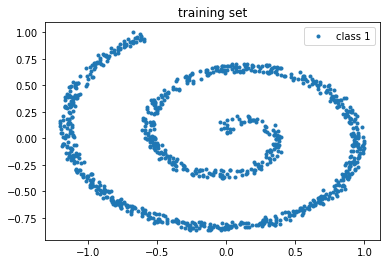

In [5]:
X = get_data(1000, 'spiral')
plt.plot(X[:,0], X[:,1], '.', label='class 1')
plt.title('training set')
plt.legend()
plt.show()

# Results

Below are the results from training the GAN comparing the output of the generator and the real distrobution.
![plot1](plot1.png)
![plot2](plot2.png)
![plot3](plot3.png)

## Load Data

In [6]:
def get_distribution_sampler(data_type):
    return lambda n: torch.Tensor(get_data(n, data_type))

def extract(v):
    l = v.data.storage().tolist()
    rv = []
    for i in range(len(l)):
        if i%2==0:
            rv.append([])
            rv[-1].append(l[i])
        else:
            rv[-1].append(l[i])
            rv[-1]=np.asarray(rv[-1])
    return np.asarray(rv)

## Networks

In [7]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [8]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = noise_dim
        n_out = 2
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    r1,r2 = -1,1
    n = (r1 - r2) * torch.rand(size, noise_dim) + r2
    n = Variable(n)
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [9]:
def getNets():
    discriminator = DiscriminatorNet()
    generator = GeneratorNet()
    if torch.cuda.is_available():
        discriminator.cuda()
        generator.cuda()
        
    # Optimizers
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
    return generator,discriminator,g_optimizer,d_optimizer

## Optimization

In [10]:
# Loss function
loss = nn.BCELoss()

## Training

In this section we train the GAN every so oftan we plot the generated output and the real distrobution to get a sense of how well the GAN is performing.

In [11]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [12]:
def train_discriminator(discriminator,generator,optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return discriminator, error_real + error_fake, prediction_real, prediction_fake

def train_generator(discriminator,generator, optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return generator,error

### Start training

In [13]:
def train(d_type):
    generator,discriminator,g_optimizer,d_optimizer = getNets()
    d_sampler = get_distribution_sampler(d_type)

    for epoch in range(num_epochs*1000):

        # 1. Train Discriminator
        real_data = Variable(d_sampler(batch_size))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        discriminator,d_error, d_pred_real, d_pred_fake = train_discriminator(discriminator,generator,d_optimizer,
                                                                    real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(batch_size))
        # Train G
        generator,g_error = train_generator(discriminator, generator, g_optimizer, fake_data)

        # Display Progress
        if (epoch) % 500 == 0:
            print("Epoch %s: Discriminator (%s err), Generator (%s err)" %
                      (epoch, d_error.detach(), g_error.detach()))
            if matplotlib_is_available:
                print("Plotting the generated distribution...")
                # Generate fake data
                fake_data = generator(noise(1000)).detach()
                values = extract(fake_data)
                #     print(" Values: %s" % (str(values)))
                plt.title('generated fakes vs real sample')
                plt.plot(values[:,0], values[:,1], '.', label='fake')
                values = extract(d_sampler(1000))
                plt.plot(values[:,0], values[:,1], '.', label='real')
                plt.grid(True)
                plt.show()


# Line

In [14]:
# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 10


noise_dim=2
batch_size = 5

Epoch 0: Discriminator (tensor(1.4044) err), Generator (tensor(0.7276) err)
Plotting the generated distribution...


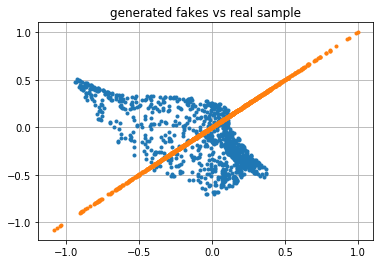

Epoch 500: Discriminator (tensor(1.4850) err), Generator (tensor(0.8343) err)
Plotting the generated distribution...


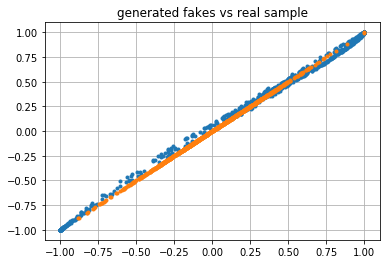

Epoch 1000: Discriminator (tensor(1.3919) err), Generator (tensor(0.7701) err)
Plotting the generated distribution...


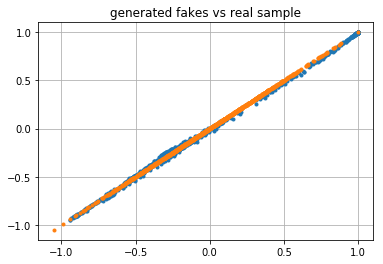

Epoch 1500: Discriminator (tensor(1.4955) err), Generator (tensor(0.7893) err)
Plotting the generated distribution...


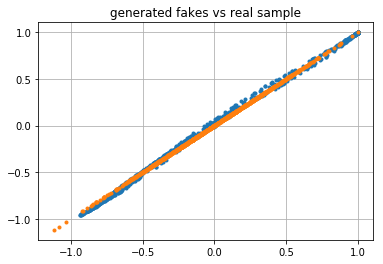

Epoch 2000: Discriminator (tensor(1.5342) err), Generator (tensor(0.8858) err)
Plotting the generated distribution...


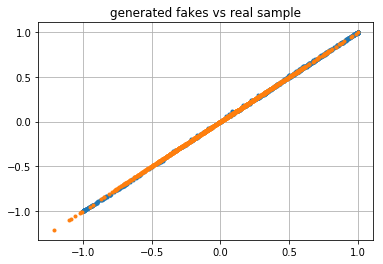

Epoch 2500: Discriminator (tensor(1.3621) err), Generator (tensor(0.7477) err)
Plotting the generated distribution...


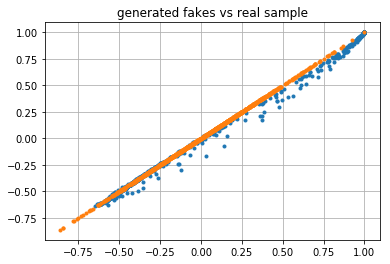

Epoch 3000: Discriminator (tensor(0.8540) err), Generator (tensor(0.6697) err)
Plotting the generated distribution...


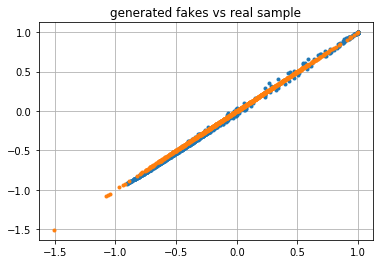

Epoch 3500: Discriminator (tensor(1.4199) err), Generator (tensor(0.8040) err)
Plotting the generated distribution...


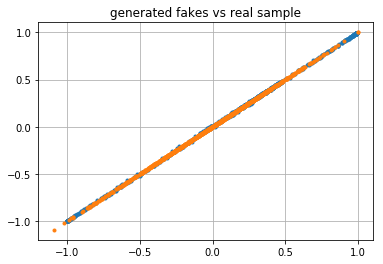

Epoch 4000: Discriminator (tensor(0.9874) err), Generator (tensor(0.7362) err)
Plotting the generated distribution...


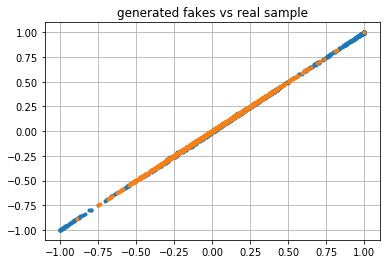

Epoch 4500: Discriminator (tensor(1.2749) err), Generator (tensor(0.7551) err)
Plotting the generated distribution...


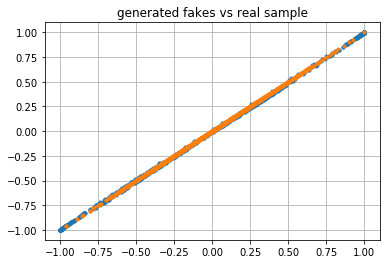

Epoch 5000: Discriminator (tensor(1.4403) err), Generator (tensor(0.8230) err)
Plotting the generated distribution...


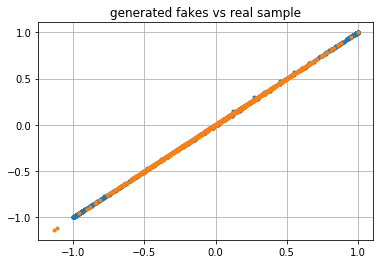

Epoch 5500: Discriminator (tensor(1.4055) err), Generator (tensor(0.8277) err)
Plotting the generated distribution...


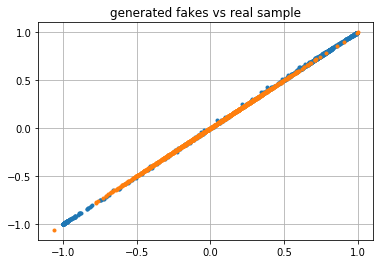

Epoch 6000: Discriminator (tensor(1.3933) err), Generator (tensor(0.7645) err)
Plotting the generated distribution...


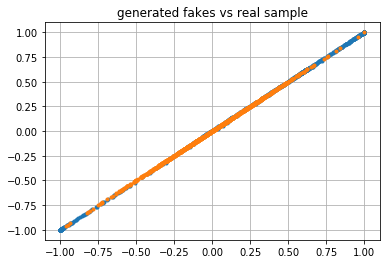

Epoch 6500: Discriminator (tensor(1.1123) err), Generator (tensor(0.7391) err)
Plotting the generated distribution...


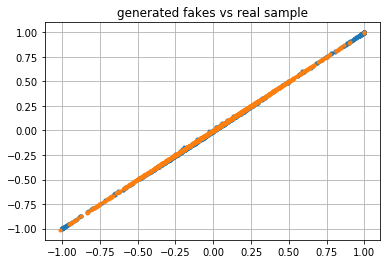

Epoch 7000: Discriminator (tensor(1.2377) err), Generator (tensor(0.7418) err)
Plotting the generated distribution...


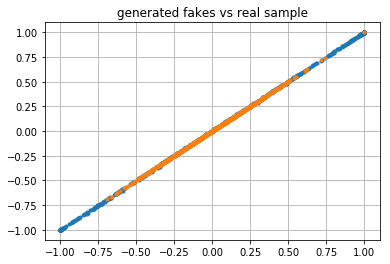

Epoch 7500: Discriminator (tensor(1.3615) err), Generator (tensor(0.6633) err)
Plotting the generated distribution...


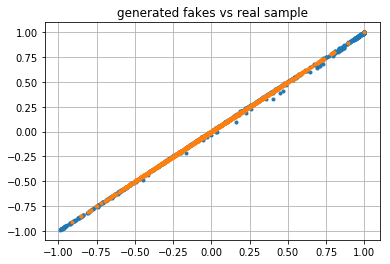

Epoch 8000: Discriminator (tensor(1.0926) err), Generator (tensor(0.7841) err)
Plotting the generated distribution...


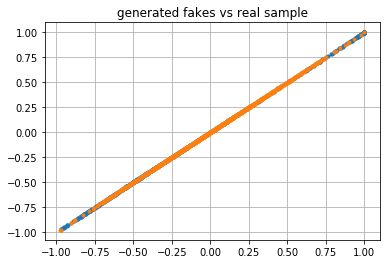

Epoch 8500: Discriminator (tensor(1.3628) err), Generator (tensor(0.7857) err)
Plotting the generated distribution...


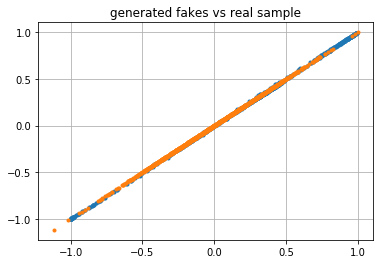

Epoch 9000: Discriminator (tensor(1.3978) err), Generator (tensor(0.7453) err)
Plotting the generated distribution...


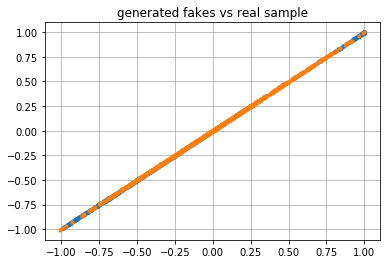

Epoch 9500: Discriminator (tensor(1.3981) err), Generator (tensor(0.7628) err)
Plotting the generated distribution...


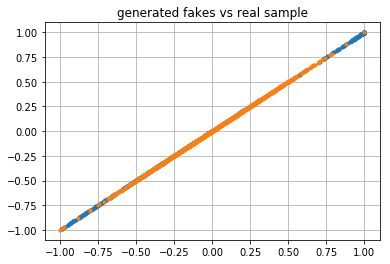

In [15]:
train('line')

# Par

In [16]:
# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 20

noise_dim=2
batch_size = 2000

Epoch 0: Discriminator (tensor(1.3861) err), Generator (tensor(0.6719) err)
Plotting the generated distribution...


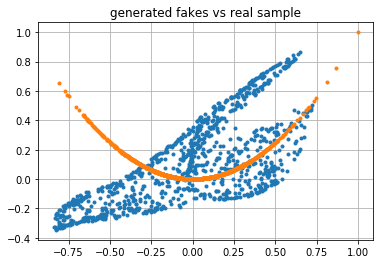

Epoch 500: Discriminator (tensor(1.3590) err), Generator (tensor(0.6892) err)
Plotting the generated distribution...


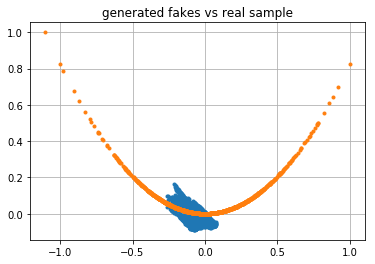

Epoch 1000: Discriminator (tensor(1.4534) err), Generator (tensor(0.6271) err)
Plotting the generated distribution...


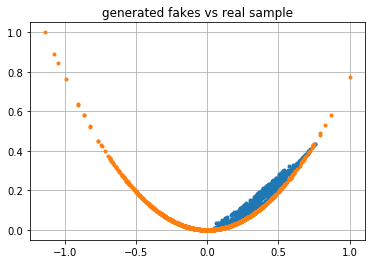

Epoch 1500: Discriminator (tensor(1.3764) err), Generator (tensor(0.7116) err)
Plotting the generated distribution...


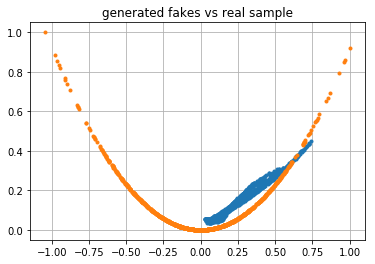

Epoch 2000: Discriminator (tensor(1.3878) err), Generator (tensor(0.7671) err)
Plotting the generated distribution...


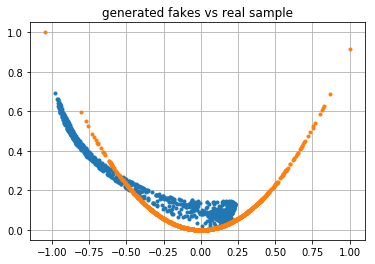

Epoch 2500: Discriminator (tensor(1.3404) err), Generator (tensor(0.7071) err)
Plotting the generated distribution...


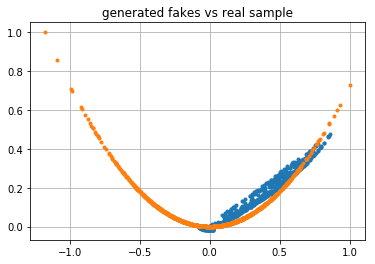

Epoch 3000: Discriminator (tensor(1.4009) err), Generator (tensor(0.7237) err)
Plotting the generated distribution...


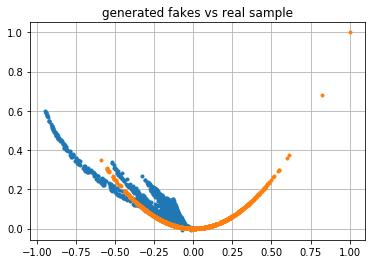

Epoch 3500: Discriminator (tensor(1.3988) err), Generator (tensor(0.7679) err)
Plotting the generated distribution...


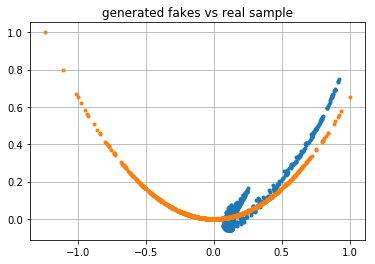

Epoch 4000: Discriminator (tensor(1.3985) err), Generator (tensor(0.7211) err)
Plotting the generated distribution...


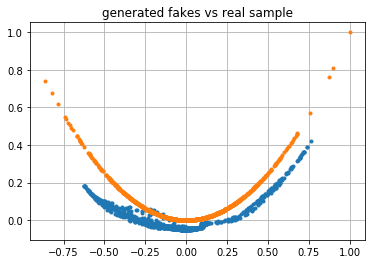

Epoch 4500: Discriminator (tensor(1.4489) err), Generator (tensor(0.7070) err)
Plotting the generated distribution...


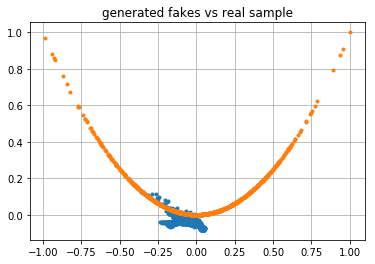

Epoch 5000: Discriminator (tensor(1.4090) err), Generator (tensor(0.6521) err)
Plotting the generated distribution...


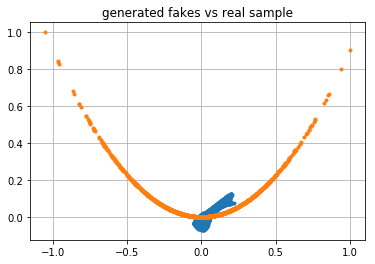

Epoch 5500: Discriminator (tensor(1.3620) err), Generator (tensor(0.7007) err)
Plotting the generated distribution...


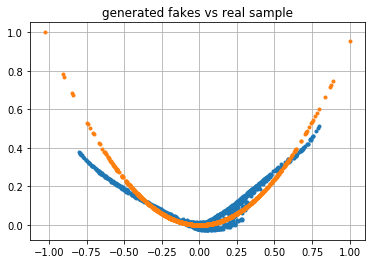

Epoch 6000: Discriminator (tensor(1.4208) err), Generator (tensor(0.7496) err)
Plotting the generated distribution...


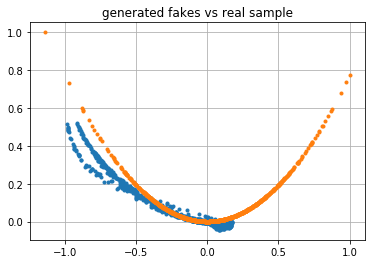

Epoch 6500: Discriminator (tensor(1.3415) err), Generator (tensor(0.7788) err)
Plotting the generated distribution...


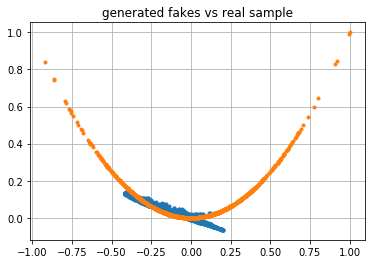

Epoch 7000: Discriminator (tensor(1.3874) err), Generator (tensor(0.6993) err)
Plotting the generated distribution...


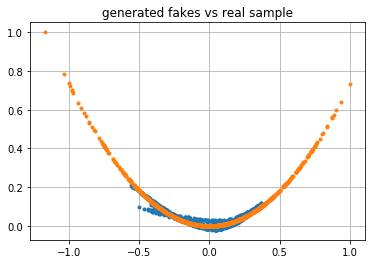

Epoch 7500: Discriminator (tensor(1.3824) err), Generator (tensor(0.6955) err)
Plotting the generated distribution...


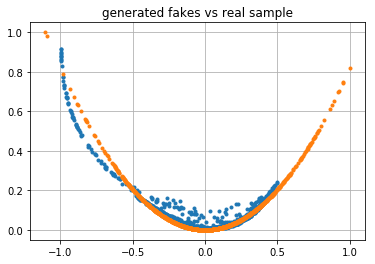

Epoch 8000: Discriminator (tensor(1.3943) err), Generator (tensor(0.7120) err)
Plotting the generated distribution...


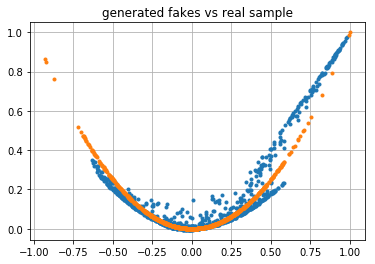

Epoch 8500: Discriminator (tensor(1.3804) err), Generator (tensor(0.7088) err)
Plotting the generated distribution...


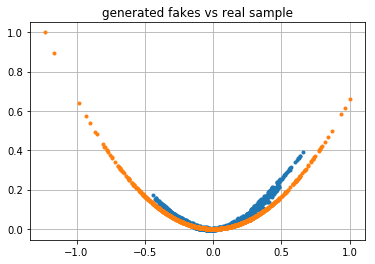

Epoch 9000: Discriminator (tensor(1.3751) err), Generator (tensor(0.7166) err)
Plotting the generated distribution...


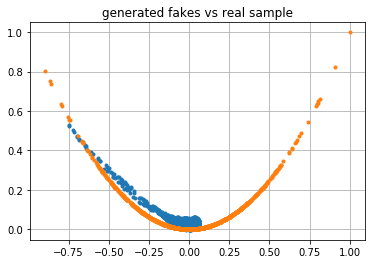

Epoch 9500: Discriminator (tensor(1.3877) err), Generator (tensor(0.7032) err)
Plotting the generated distribution...


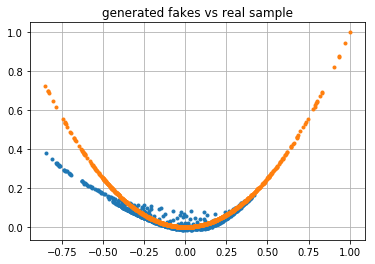

Epoch 10000: Discriminator (tensor(1.3861) err), Generator (tensor(0.7044) err)
Plotting the generated distribution...


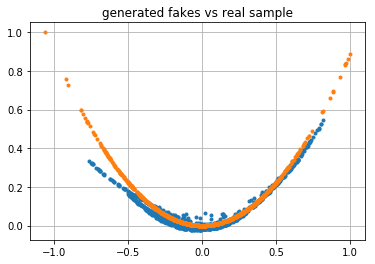

Epoch 10500: Discriminator (tensor(1.3882) err), Generator (tensor(0.6981) err)
Plotting the generated distribution...


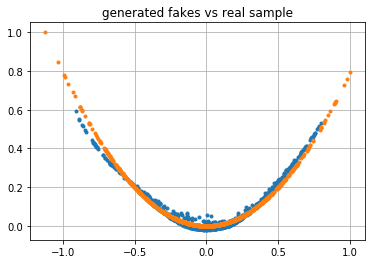

Epoch 11000: Discriminator (tensor(1.3893) err), Generator (tensor(0.6864) err)
Plotting the generated distribution...


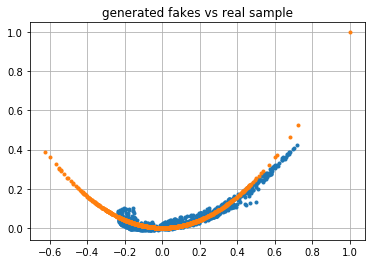

Epoch 11500: Discriminator (tensor(1.3516) err), Generator (tensor(0.7288) err)
Plotting the generated distribution...


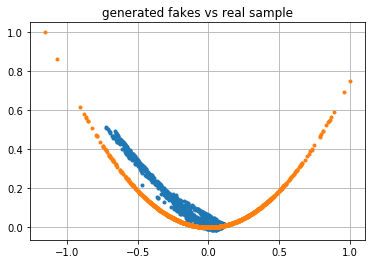

Epoch 12000: Discriminator (tensor(1.3855) err), Generator (tensor(0.6771) err)
Plotting the generated distribution...


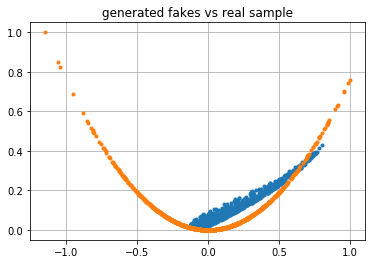

Epoch 12500: Discriminator (tensor(1.3694) err), Generator (tensor(0.7220) err)
Plotting the generated distribution...


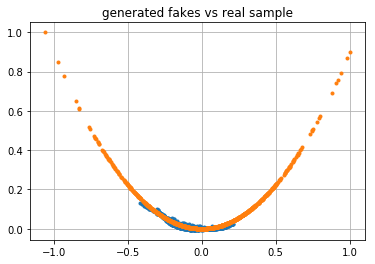

Epoch 13000: Discriminator (tensor(1.3863) err), Generator (tensor(0.7018) err)
Plotting the generated distribution...


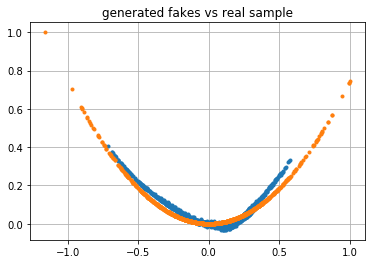

Epoch 13500: Discriminator (tensor(1.3869) err), Generator (tensor(0.7016) err)
Plotting the generated distribution...


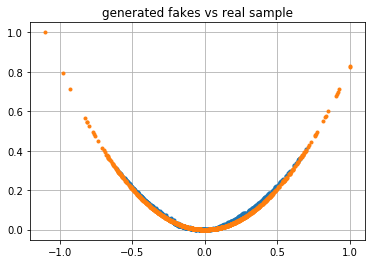

Epoch 14000: Discriminator (tensor(1.3845) err), Generator (tensor(0.7063) err)
Plotting the generated distribution...


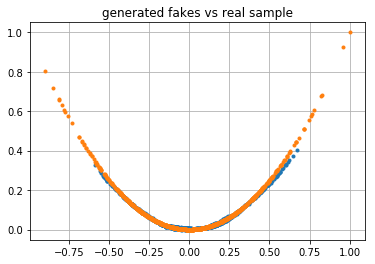

Epoch 14500: Discriminator (tensor(1.3852) err), Generator (tensor(0.6902) err)
Plotting the generated distribution...


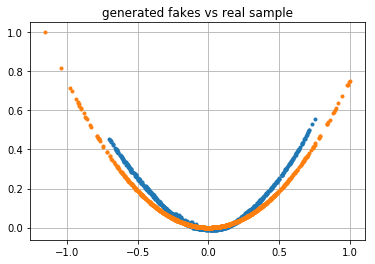

Epoch 15000: Discriminator (tensor(1.3886) err), Generator (tensor(0.7000) err)
Plotting the generated distribution...


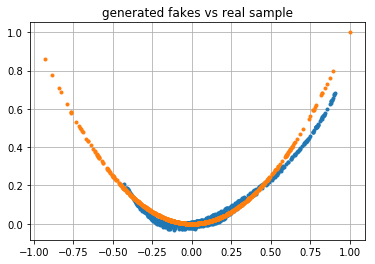

Epoch 15500: Discriminator (tensor(1.4018) err), Generator (tensor(0.8252) err)
Plotting the generated distribution...


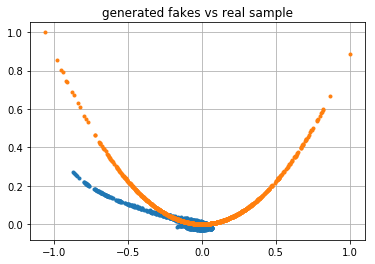

Epoch 16000: Discriminator (tensor(1.3631) err), Generator (tensor(0.7353) err)
Plotting the generated distribution...


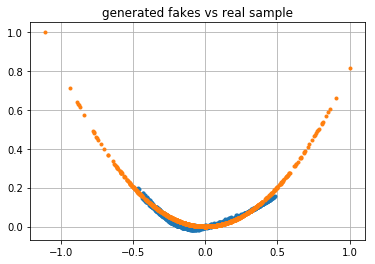

Epoch 16500: Discriminator (tensor(1.3847) err), Generator (tensor(0.6841) err)
Plotting the generated distribution...


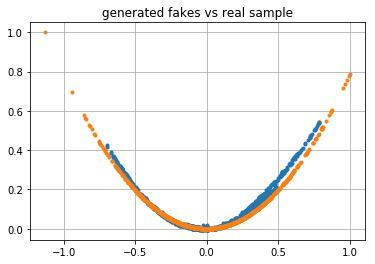

Epoch 17000: Discriminator (tensor(1.3846) err), Generator (tensor(0.6907) err)
Plotting the generated distribution...


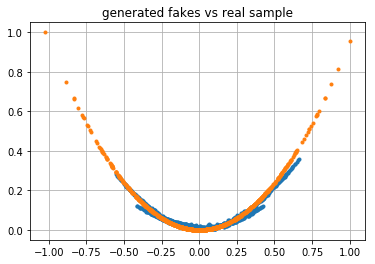

Epoch 17500: Discriminator (tensor(1.3898) err), Generator (tensor(0.6959) err)
Plotting the generated distribution...


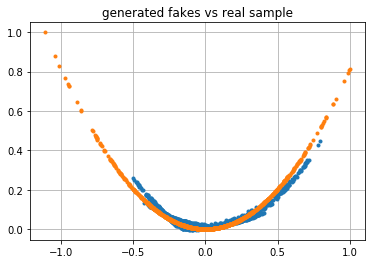

Epoch 18000: Discriminator (tensor(1.3856) err), Generator (tensor(0.6987) err)
Plotting the generated distribution...


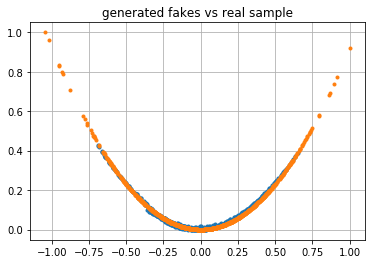

Epoch 18500: Discriminator (tensor(1.3847) err), Generator (tensor(0.6875) err)
Plotting the generated distribution...


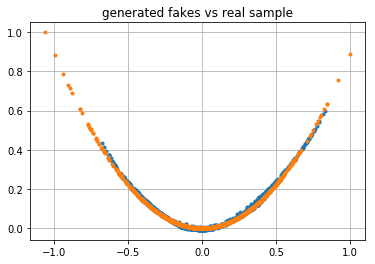

Epoch 19000: Discriminator (tensor(1.3857) err), Generator (tensor(0.6776) err)
Plotting the generated distribution...


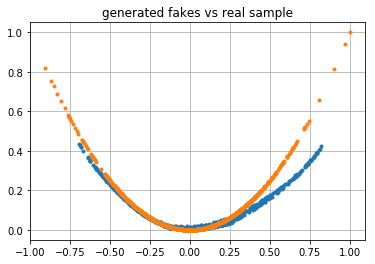

Epoch 19500: Discriminator (tensor(1.3814) err), Generator (tensor(0.6872) err)
Plotting the generated distribution...


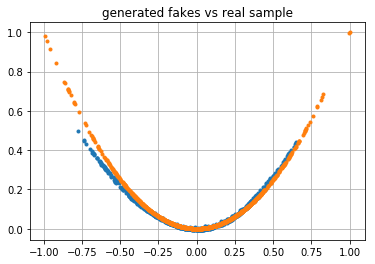

In [17]:
train('par')

# Spiral

In [18]:
# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 500

noise_dim=2
batch_size = 2000

Epoch 0: Discriminator (tensor(1.3908) err), Generator (tensor(0.6767) err)
Plotting the generated distribution...


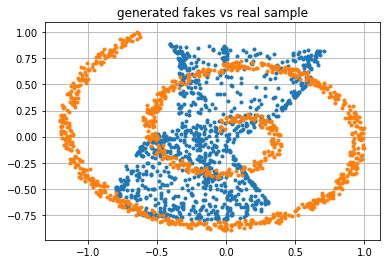

Epoch 500: Discriminator (tensor(1.3951) err), Generator (tensor(0.7594) err)
Plotting the generated distribution...


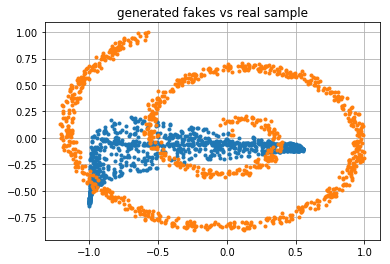

Epoch 1000: Discriminator (tensor(1.3774) err), Generator (tensor(0.7907) err)
Plotting the generated distribution...


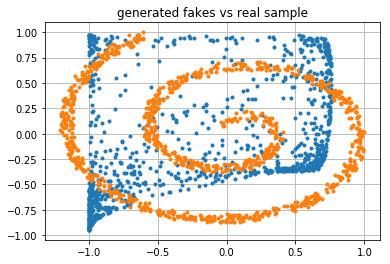

Epoch 1500: Discriminator (tensor(1.4044) err), Generator (tensor(0.6685) err)
Plotting the generated distribution...


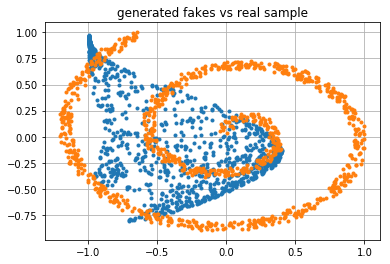

Epoch 2000: Discriminator (tensor(1.2849) err), Generator (tensor(0.8416) err)
Plotting the generated distribution...


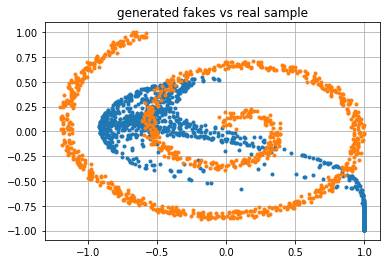

Epoch 2500: Discriminator (tensor(1.3977) err), Generator (tensor(0.6975) err)
Plotting the generated distribution...


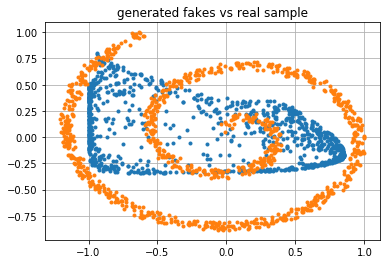

Epoch 3000: Discriminator (tensor(1.3213) err), Generator (tensor(0.7376) err)
Plotting the generated distribution...


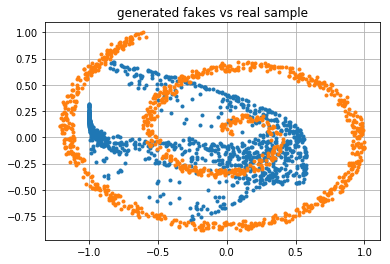

Epoch 3500: Discriminator (tensor(1.3344) err), Generator (tensor(0.7589) err)
Plotting the generated distribution...


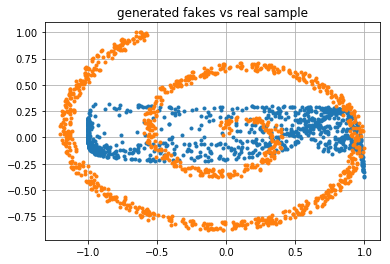

Epoch 4000: Discriminator (tensor(1.3357) err), Generator (tensor(0.7929) err)
Plotting the generated distribution...


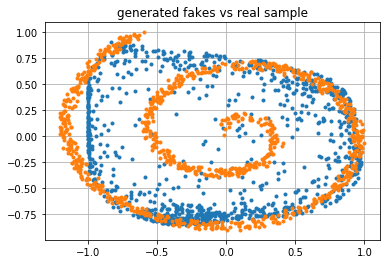

Epoch 4500: Discriminator (tensor(1.2988) err), Generator (tensor(0.7829) err)
Plotting the generated distribution...


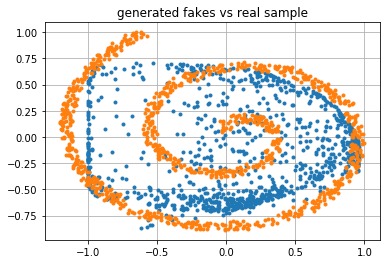

Epoch 5000: Discriminator (tensor(1.3195) err), Generator (tensor(0.7622) err)
Plotting the generated distribution...


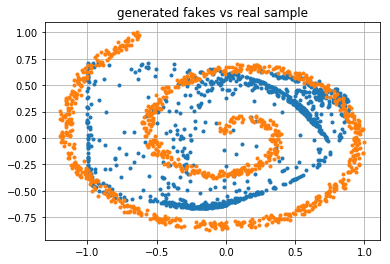

Epoch 5500: Discriminator (tensor(1.2782) err), Generator (tensor(0.8690) err)
Plotting the generated distribution...


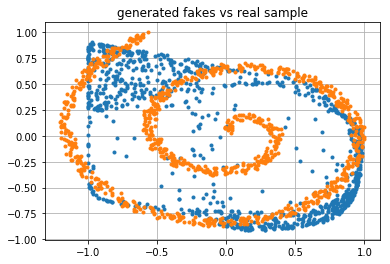

Epoch 6000: Discriminator (tensor(1.2984) err), Generator (tensor(0.7808) err)
Plotting the generated distribution...


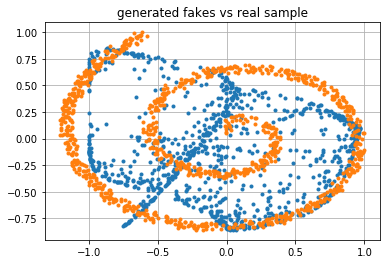

Epoch 6500: Discriminator (tensor(1.2718) err), Generator (tensor(0.7728) err)
Plotting the generated distribution...


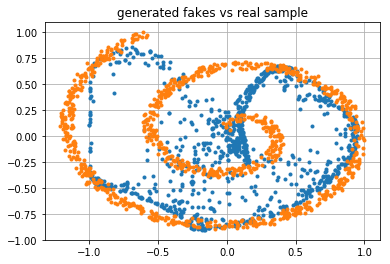

Epoch 7000: Discriminator (tensor(1.2763) err), Generator (tensor(0.8129) err)
Plotting the generated distribution...


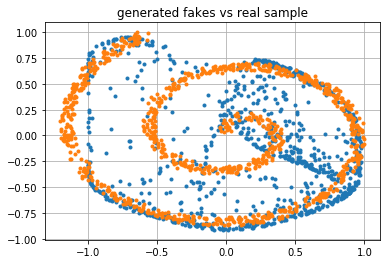

Epoch 7500: Discriminator (tensor(1.2926) err), Generator (tensor(0.8215) err)
Plotting the generated distribution...


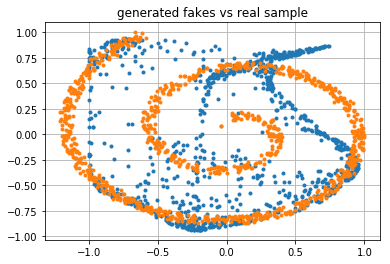

Epoch 8000: Discriminator (tensor(1.2924) err), Generator (tensor(0.7789) err)
Plotting the generated distribution...


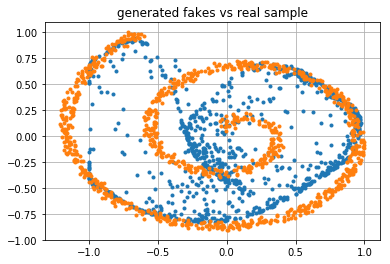

Epoch 8500: Discriminator (tensor(1.2707) err), Generator (tensor(0.7640) err)
Plotting the generated distribution...


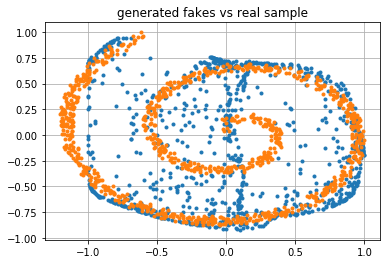

Epoch 9000: Discriminator (tensor(1.2776) err), Generator (tensor(0.7971) err)
Plotting the generated distribution...


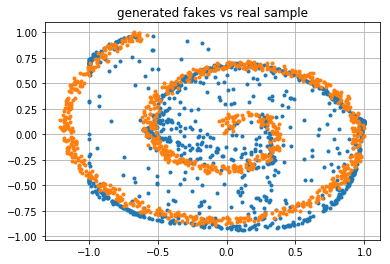

Epoch 9500: Discriminator (tensor(1.2677) err), Generator (tensor(0.7841) err)
Plotting the generated distribution...


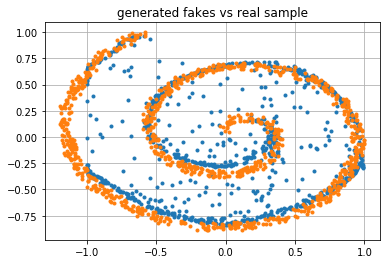

Epoch 10000: Discriminator (tensor(1.2676) err), Generator (tensor(0.7902) err)
Plotting the generated distribution...


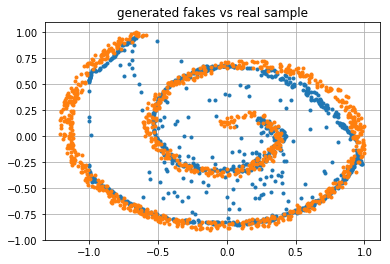

Epoch 10500: Discriminator (tensor(1.2942) err), Generator (tensor(0.8013) err)
Plotting the generated distribution...


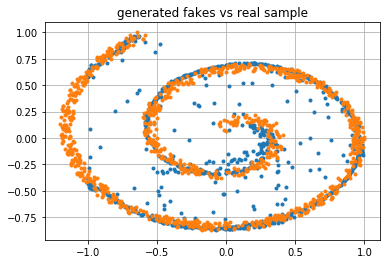

Epoch 11000: Discriminator (tensor(1.2820) err), Generator (tensor(0.7648) err)
Plotting the generated distribution...


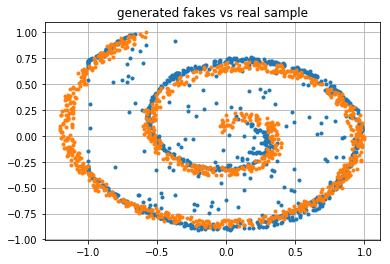

Epoch 11500: Discriminator (tensor(1.2679) err), Generator (tensor(0.7700) err)
Plotting the generated distribution...


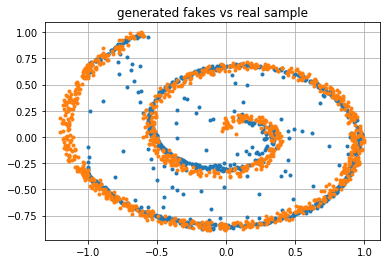

Epoch 12000: Discriminator (tensor(1.2994) err), Generator (tensor(0.8564) err)
Plotting the generated distribution...


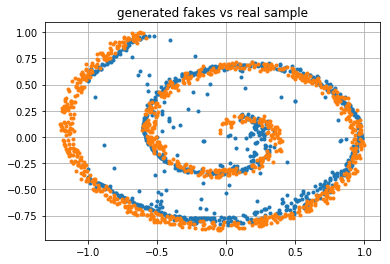

Epoch 12500: Discriminator (tensor(1.2911) err), Generator (tensor(0.8111) err)
Plotting the generated distribution...


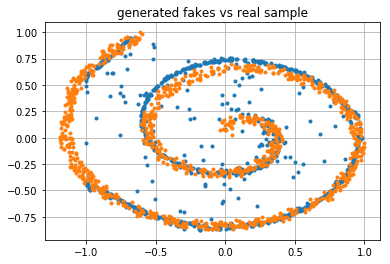

Epoch 13000: Discriminator (tensor(1.2798) err), Generator (tensor(0.7991) err)
Plotting the generated distribution...


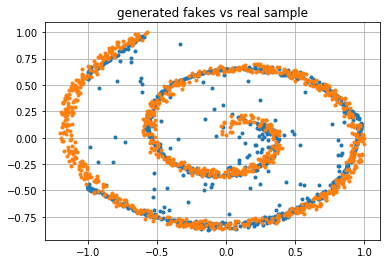

Epoch 13500: Discriminator (tensor(1.2789) err), Generator (tensor(0.8353) err)
Plotting the generated distribution...


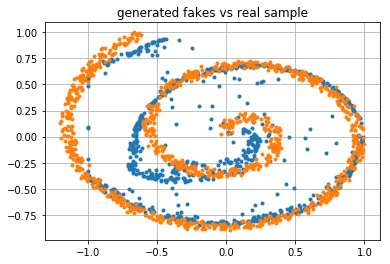

Epoch 14000: Discriminator (tensor(1.2820) err), Generator (tensor(0.8088) err)
Plotting the generated distribution...


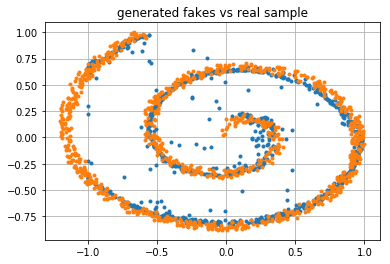

Epoch 14500: Discriminator (tensor(1.2837) err), Generator (tensor(0.7537) err)
Plotting the generated distribution...


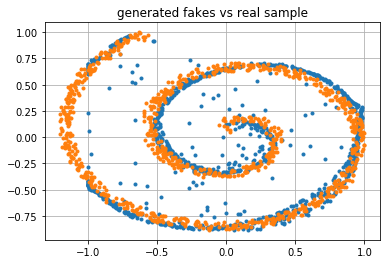

Epoch 15000: Discriminator (tensor(1.2998) err), Generator (tensor(0.7889) err)
Plotting the generated distribution...


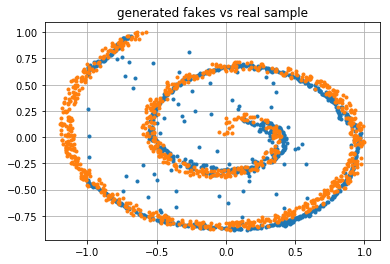

Epoch 15500: Discriminator (tensor(1.2818) err), Generator (tensor(0.7799) err)
Plotting the generated distribution...


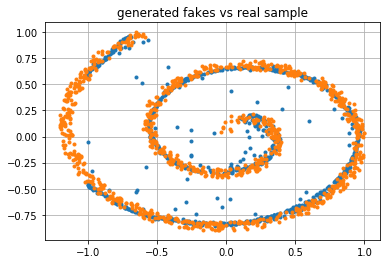

Epoch 16000: Discriminator (tensor(1.2796) err), Generator (tensor(0.7782) err)
Plotting the generated distribution...


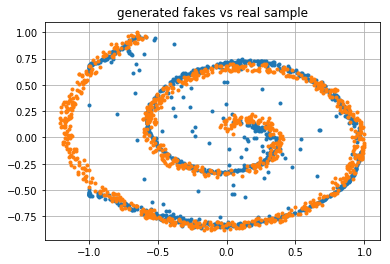

Epoch 16500: Discriminator (tensor(1.2938) err), Generator (tensor(0.7548) err)
Plotting the generated distribution...


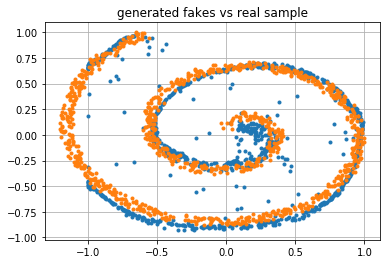

Epoch 17000: Discriminator (tensor(1.3037) err), Generator (tensor(0.7707) err)
Plotting the generated distribution...


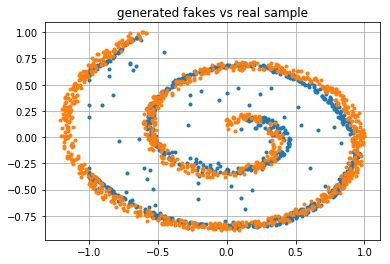

Epoch 17500: Discriminator (tensor(1.2754) err), Generator (tensor(0.7667) err)
Plotting the generated distribution...


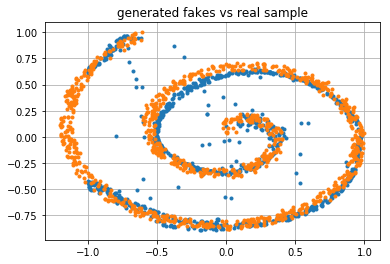

Epoch 18000: Discriminator (tensor(1.2814) err), Generator (tensor(0.7735) err)
Plotting the generated distribution...


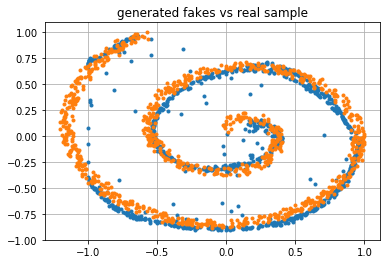

Epoch 18500: Discriminator (tensor(1.2809) err), Generator (tensor(0.7728) err)
Plotting the generated distribution...


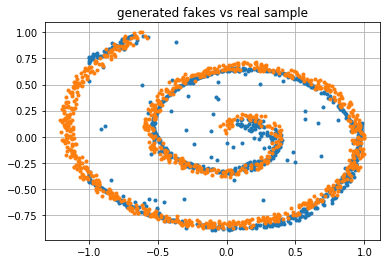

Epoch 19000: Discriminator (tensor(1.2903) err), Generator (tensor(0.8031) err)
Plotting the generated distribution...


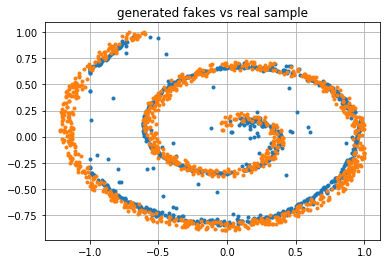

Epoch 19500: Discriminator (tensor(1.2869) err), Generator (tensor(0.8011) err)
Plotting the generated distribution...


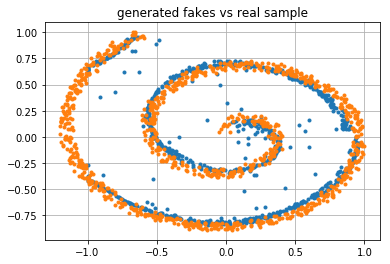

Epoch 20000: Discriminator (tensor(1.2898) err), Generator (tensor(0.7558) err)
Plotting the generated distribution...


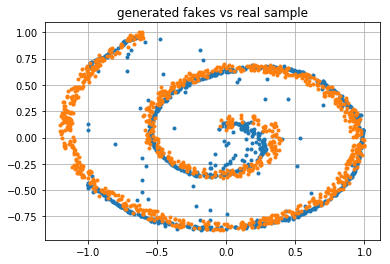

Epoch 20500: Discriminator (tensor(1.2913) err), Generator (tensor(0.7963) err)
Plotting the generated distribution...


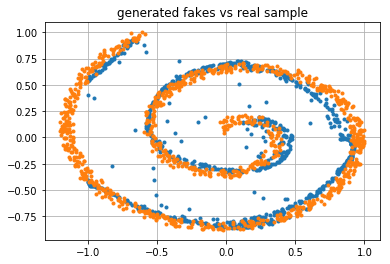

Epoch 21000: Discriminator (tensor(1.2959) err), Generator (tensor(0.7793) err)
Plotting the generated distribution...


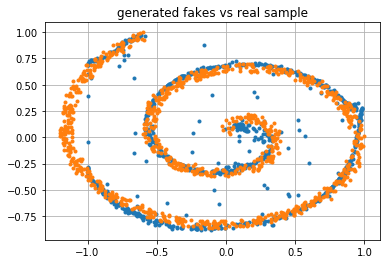

Epoch 21500: Discriminator (tensor(1.2976) err), Generator (tensor(0.7800) err)
Plotting the generated distribution...


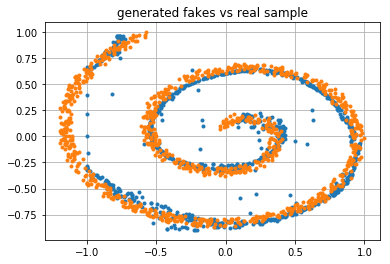

Epoch 22000: Discriminator (tensor(1.2815) err), Generator (tensor(0.7695) err)
Plotting the generated distribution...


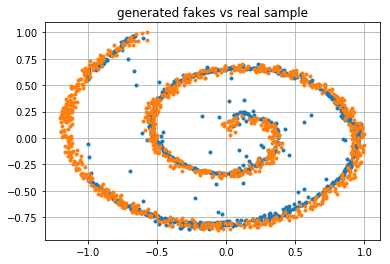

Epoch 22500: Discriminator (tensor(1.2852) err), Generator (tensor(0.7788) err)
Plotting the generated distribution...


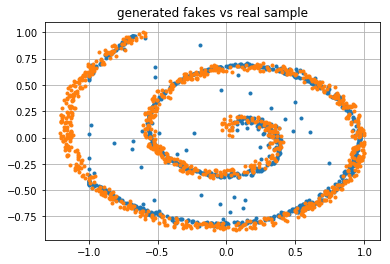

Epoch 23000: Discriminator (tensor(1.2839) err), Generator (tensor(0.7603) err)
Plotting the generated distribution...


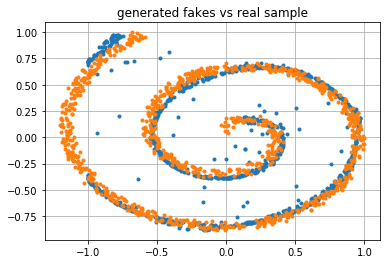

Epoch 23500: Discriminator (tensor(1.2922) err), Generator (tensor(0.7629) err)
Plotting the generated distribution...


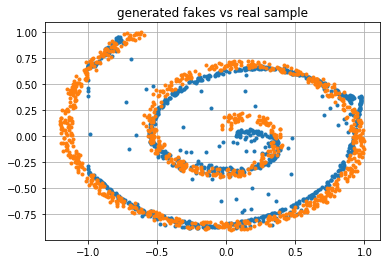

Epoch 24000: Discriminator (tensor(1.2935) err), Generator (tensor(0.7733) err)
Plotting the generated distribution...


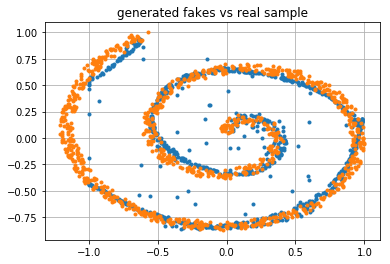

Epoch 24500: Discriminator (tensor(1.2840) err), Generator (tensor(0.7761) err)
Plotting the generated distribution...


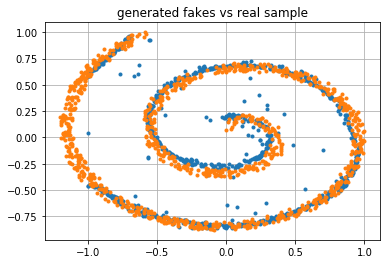

Epoch 25000: Discriminator (tensor(1.2819) err), Generator (tensor(0.7853) err)
Plotting the generated distribution...


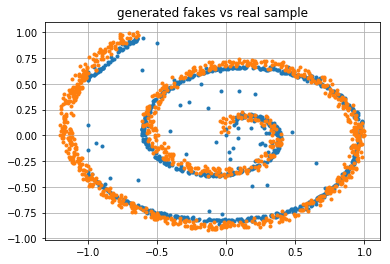

Epoch 25500: Discriminator (tensor(1.2846) err), Generator (tensor(0.7785) err)
Plotting the generated distribution...


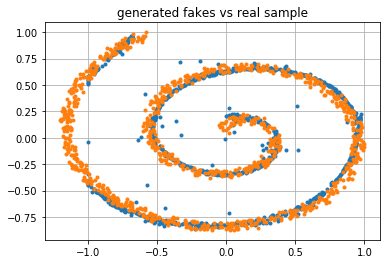

Epoch 26000: Discriminator (tensor(1.2887) err), Generator (tensor(0.7543) err)
Plotting the generated distribution...


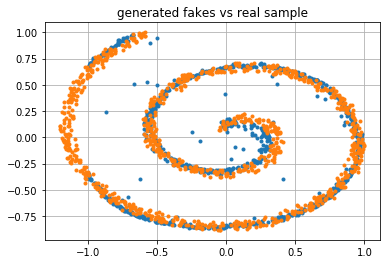

Epoch 26500: Discriminator (tensor(1.2885) err), Generator (tensor(0.7794) err)
Plotting the generated distribution...


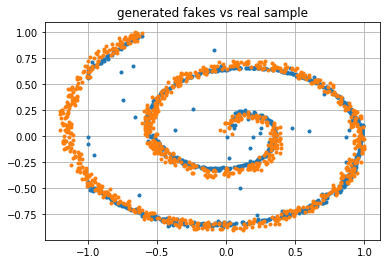

Epoch 27000: Discriminator (tensor(1.2961) err), Generator (tensor(0.7761) err)
Plotting the generated distribution...


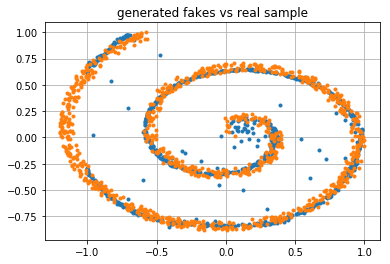

Epoch 27500: Discriminator (tensor(1.2852) err), Generator (tensor(0.7796) err)
Plotting the generated distribution...


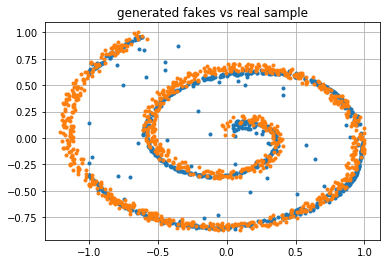

Epoch 28000: Discriminator (tensor(1.2833) err), Generator (tensor(0.7606) err)
Plotting the generated distribution...


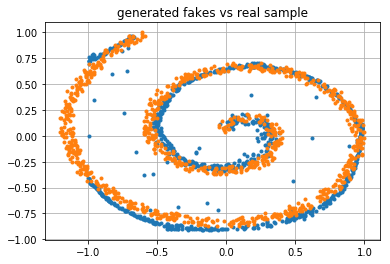

Epoch 28500: Discriminator (tensor(1.2874) err), Generator (tensor(0.7679) err)
Plotting the generated distribution...


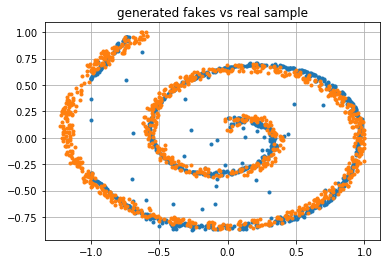

Epoch 29000: Discriminator (tensor(1.2721) err), Generator (tensor(0.7629) err)
Plotting the generated distribution...


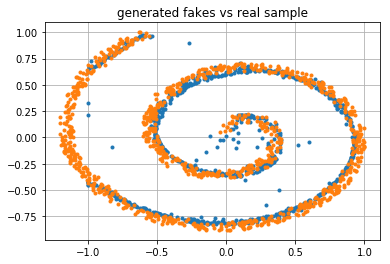

Epoch 29500: Discriminator (tensor(1.2933) err), Generator (tensor(0.7802) err)
Plotting the generated distribution...


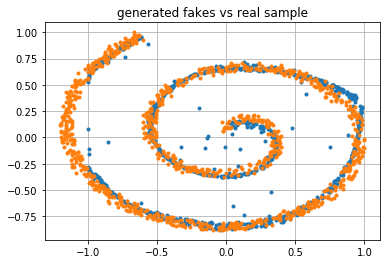

Epoch 30000: Discriminator (tensor(1.2893) err), Generator (tensor(0.7766) err)
Plotting the generated distribution...


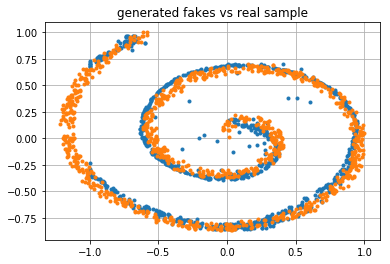

Epoch 30500: Discriminator (tensor(1.2859) err), Generator (tensor(0.7863) err)
Plotting the generated distribution...


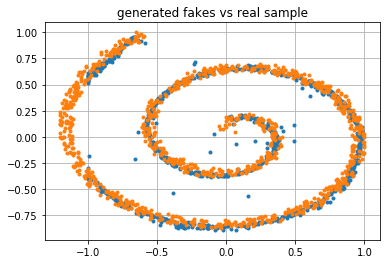

Epoch 31000: Discriminator (tensor(1.2848) err), Generator (tensor(0.7647) err)
Plotting the generated distribution...


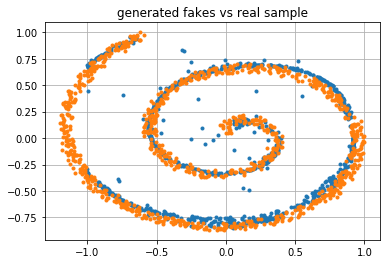

Epoch 31500: Discriminator (tensor(1.2913) err), Generator (tensor(0.7739) err)
Plotting the generated distribution...


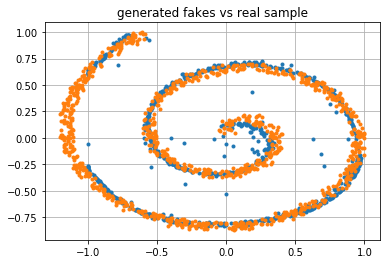

Epoch 32000: Discriminator (tensor(1.2934) err), Generator (tensor(0.7729) err)
Plotting the generated distribution...


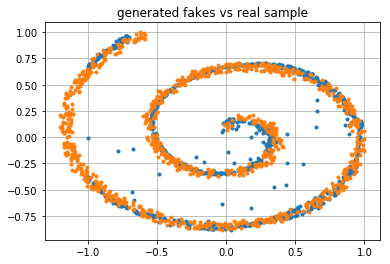

Epoch 32500: Discriminator (tensor(1.2921) err), Generator (tensor(0.7650) err)
Plotting the generated distribution...


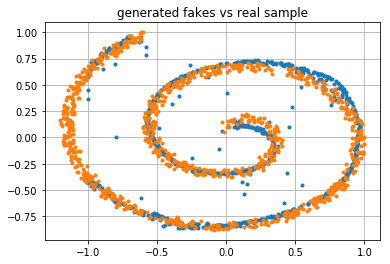

Epoch 33000: Discriminator (tensor(1.2827) err), Generator (tensor(0.7726) err)
Plotting the generated distribution...


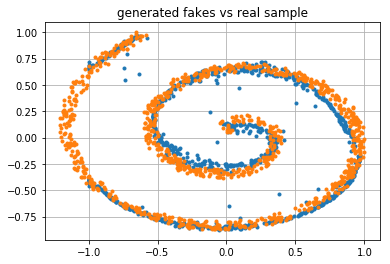

Epoch 33500: Discriminator (tensor(1.2837) err), Generator (tensor(0.7546) err)
Plotting the generated distribution...


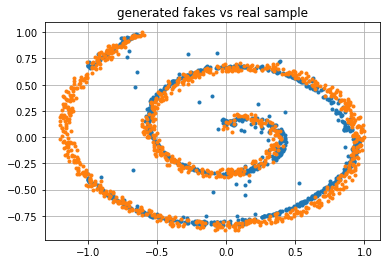

Epoch 34000: Discriminator (tensor(1.3017) err), Generator (tensor(0.7692) err)
Plotting the generated distribution...


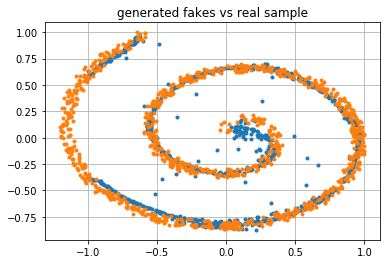

Epoch 34500: Discriminator (tensor(1.2921) err), Generator (tensor(0.7588) err)
Plotting the generated distribution...


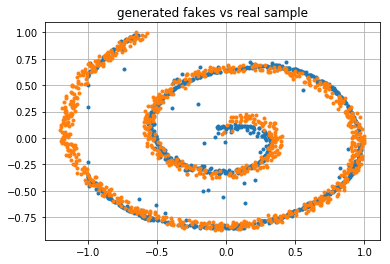

Epoch 35000: Discriminator (tensor(1.2732) err), Generator (tensor(0.7767) err)
Plotting the generated distribution...


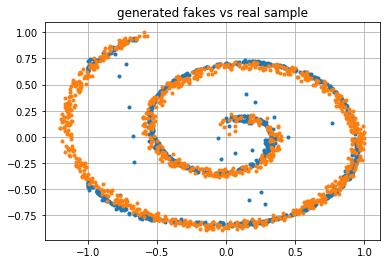

Epoch 35500: Discriminator (tensor(1.2847) err), Generator (tensor(0.7752) err)
Plotting the generated distribution...


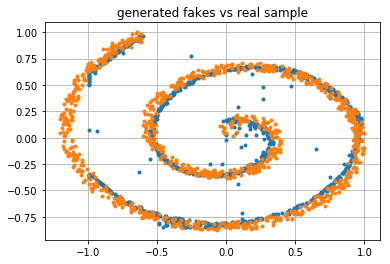

Epoch 36000: Discriminator (tensor(1.2934) err), Generator (tensor(0.7598) err)
Plotting the generated distribution...


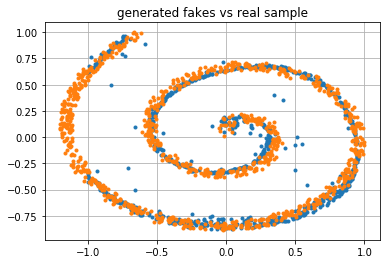

Epoch 36500: Discriminator (tensor(1.2772) err), Generator (tensor(0.7869) err)
Plotting the generated distribution...


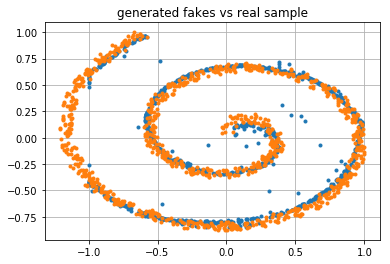

Epoch 37000: Discriminator (tensor(1.2813) err), Generator (tensor(0.7823) err)
Plotting the generated distribution...


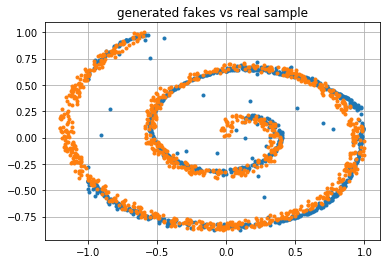

KeyboardInterrupt: 

In [19]:
train('spiral')